# Example ? Electron Cooling

In this example, we will show how to use the electron cooling module, found in [*darkhistory.elec.elec_cooling*](https://darkhistory.readthedocs.io/en/master/_autosummary/darkhistory/electrons/darkhistory.electrons.elec_cooling.html). This module takes an injected electron with some initial energy, and cools it completely through inverse Compton scattering (ICS) as well as ionization, excitation (both on HI, HeI and HeII) as well as Coulomb heating from free electrons. 

## Initialization

Let's load the stuff that we need. The function of interest is [*get_elec_cooling_tf*](https://darkhistory.readthedocs.io/en/master/_autosummary/darkhistory/electrons/elec_cooling/darkhistory.electrons.elec_cooling.get_elec_cooling_tf.html).

We have also imported the default binning for photons and electrons used throughout DarkHistory using [*config.load_data*](https://darkhistory.readthedocs.io/en/master/_autosummary/config/config.load_data.html).


In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%matplotlib inline

In [24]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

import numpy as np

from config import load_data
import darkhistory.physics as phys
from darkhistory.electrons.elec_cooling import get_elec_cooling_tf

photeng = load_data('binning')['phot']
eleceng = load_data('binning')['elec']

## Electron Cooling Function: [*get_elec_cooling_tf*](https://darkhistory.readthedocs.io/en/master/_autosummary/darkhistory/electrons/elec_cooling/darkhistory.electrons.elec_cooling.get_elec_cooling_tf.html)

The user should refer to the online documentation for details on how to use [*get_elec_cooling_tf*](https://darkhistory.readthedocs.io/en/master/_autosummary/darkhistory/electrons/elec_cooling/darkhistory.electrons.elec_cooling.get_elec_cooling_tf.html). In the simplest default case, we just need to give the function the electron and photon abscissae of interest, the redshift, and the ionization levels of hydrogen and helium.

If we do not specify any ICS transfer functions to the function, DarkHistory automatically loads the required transfer functions from the downloaded data. If this is the first time the transfer functions are loaded, the successful completion of the import would look like this:

```
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******
```

In [25]:
rs = 600
# This function returns the baseline value of xHII. 
xHII  = phys.xHII_std(rs)

elec_cooling_info = get_elec_cooling_tf(
    eleceng, photeng, rs, xHII, check_conservation_eng=True, verbose=True
)


***************************************************
rs:  600
injected energy:  1.029782576544676
Energy in low energy electrons:  1.029782576544676
Energy in photons - Continuum:  0.0
Deposited in ionization:  0.0
Deposited in excitation:  0.0
Deposited in heating:  0.0
Energy is conserved up to (%):  0.0
Deposited in ICS (Numerical Error):  0.0
Energy conservation with deposited (%):  0.0
***************************************************
***************************************************
rs:  600
injected energy:  1.0920351523673162
Energy in low energy electrons:  1.0920351523673162
Energy in photons - Continuum:  0.0
Deposited in ionization:  0.0
Deposited in excitation:  0.0
Deposited in heating:  0.0
Energy is conserved up to (%):  0.0
Deposited in ICS (Numerical Error):  0.0
Energy conservation with deposited (%):  0.0
***************************************************
***************************************************
rs:  600
injected energy:  1.1580510305357166
Energy in 

Deposited in ionization:  0.0
Deposited in excitation:  0.0
Deposited in heating:  0.0
Energy is conserved up to (%):  0.0
Deposited in ICS (Numerical Error):  0.0
Energy conservation with deposited (%):  0.0
***************************************************
***************************************************
rs:  600
injected energy:  134.43275288149016
Energy in low energy electrons:  134.43275288149016
Energy in photons - Continuum:  0.0
Deposited in ionization:  0.0
Deposited in excitation:  0.0
Deposited in heating:  0.0
Energy is conserved up to (%):  0.0
Deposited in ICS (Numerical Error):  0.0
Energy conservation with deposited (%):  0.0
***************************************************
***************************************************
rs:  600
injected energy:  142.55950248084264
Energy in low energy electrons:  142.55950248084264
Energy in photons - Continuum:  0.0
Deposited in ionization:  0.0
Deposited in excitation:  0.0
Deposited in heating:  0.0
Energy is conserved

Deposited in excitation:  516.1651901276954
Deposited in heating:  13.12937320402443
Energy is conserved up to (%):  -0.018840240793113396
Deposited in ICS (Numerical Error):  -1.2926883375782023
Energy conservation with deposited (%):  9.660001177780076e-14
***************************************************
***************************************************
rs:  600
injected energy:  7276.0966711129295
Energy in low energy electrons:  4265.761486618575
Energy in photons - Continuum:  1657.9829856264403
Deposited in ionization:  781.5902051072211
Deposited in excitation:  558.0299492685575
Deposited in heating:  14.140646444877452
Energy is conserved up to (%):  -0.01935930783237338
Deposited in ICS (Numerical Error):  -1.4086019527473637
Energy conservation with deposited (%):  7.613379884935428e-14
***************************************************
***************************************************
rs:  600
injected energy:  7715.952394060849
Energy in low energy electrons:  4380

Energy is conserved up to (%):  -0.0038457905787085273
Deposited in ICS (Numerical Error):  -14.28191293325824
Energy conservation with deposited (%):  -8.892383759556211e-14
***************************************************
***************************************************
rs:  600
injected energy:  393814.61461284145
Energy in low energy electrons:  10226.724161346068
Energy in photons - Continuum:  377065.91135310265
Deposited in ionization:  3671.632975655972
Deposited in excitation:  2797.7550363280916
Deposited in heating:  67.04539973576138
Energy is conserved up to (%):  -0.0036703344139034618
Deposited in ICS (Numerical Error):  -14.45431332673358
Energy conservation with deposited (%):  -9.721065538993897e-14
***************************************************
***************************************************
rs:  600
injected energy:  417621.5566928854
Energy in low energy electrons:  10249.62362754183
Energy in photons - Continuum:  400829.7945785263
Deposited in ioni

Energy in low energy electrons:  10546.943282271759
Energy in photons - Continuum:  28567803.079685394
Deposited in ionization:  3823.9144658983587
Deposited in excitation:  2926.7462434522613
Deposited in heating:  76.15960307182978
Energy is conserved up to (%):  -6.706182306735525e-05
Deposited in ICS (Numerical Error):  -19.169727858813292
Energy conservation with deposited (%):  -1.3114567930563214e-14
***************************************************
***************************************************
rs:  600
injected energy:  30313192.052754264
Energy in low energy electrons:  10546.965778789025
Energy in photons - Continuum:  30295837.402069137
Deposited in ionization:  3823.9251630321223
Deposited in excitation:  2926.7558812532775
Deposited in heating:  76.17370062787361
Energy is conserved up to (%):  -6.32392607894999e-05
Deposited in ICS (Numerical Error):  -19.169838571908613
Energy conservation with deposited (%):  -1.3045841078428464e-14
*****************************

rs:  600
injected energy:  1153661941.441775
Energy in low energy electrons:  10547.153571208733
Energy in photons - Continuum:  1153644586.1982374
Deposited in ionization:  3824.01446161839
Deposited in excitation:  2926.836891068842
Deposited in heating:  76.40957047361412
Energy is conserved up to (%):  -1.6617482068723947e-06
Deposited in ICS (Numerical Error):  -19.17095717412693
Energy conservation with deposited (%):  4.757450663991709e-14
***************************************************
***************************************************
rs:  600
injected energy:  1223403291.8151124
Energy in low energy electrons:  10547.15358850753
Energy in photons - Continuum:  1223385936.571115
Deposited in ionization:  3824.0144698457057
Deposited in excitation:  2926.836898787537
Deposited in heating:  76.40996657631307
Energy is conserved up to (%):  -1.5670160882990673e-06
Deposited in ICS (Numerical Error):  -19.170926578292768
Energy conservation with deposited (%):  1.395856722562

injected energy:  112300767314.6901
Energy in low energy electrons:  10547.15373285668
Energy in photons - Continuum:  112300749959.44028
Deposited in ionization:  3824.0145384999755
Deposited in excitation:  2926.83696350354
Deposited in heating:  76.41691432732412
Energy is conserved up to (%):  -1.7072306979335534e-08
Deposited in ICS (Numerical Error):  -19.172291622041364
Energy conservation with deposited (%):  -3.572021170360293e-14
***************************************************
***************************************************
rs:  600
injected energy:  119089590694.5274
Energy in low energy electrons:  10547.15373286041
Energy in photons - Continuum:  119089573339.27753
Deposited in ionization:  3824.01453850175
Deposited in excitation:  2926.8369635052645
Deposited in heating:  76.41692326954372
Energy is conserved up to (%):  -1.609903899649258e-08
Deposited in ICS (Numerical Error):  -19.17224500199365
Energy conservation with deposited (%):  -2.909127616430189e-14
*

The output, stored in *elec_cooling_info*, is a tuple containing the following, as well as what each variable is indexed by: 

0. The secondary propagating photon transfer function $\overline{T}_\text{ICS}$ (*eleceng*, *photeng*). This spectrum has the original upscattered CMB photons **already subtracted**, and generically contains negative values at low energies. This spectrum should be viewed as a **distortion** to the CMB spectrum; 
1. The low-energy electron transfer function $\overline{T}_e$ (*eleceng*, *eleceng*); 
2. The energy deposited into ionization $\overline{R}_\text{ion}$ (*eleceng*); 
3. The energy deposited into excitation $\overline{R}_\text{exc}$ (*eleceng*);
4. The energy deposited into heating $\overline{R}_\text{heat}$ (*eleceng*); 
5. The total energy of upscattered CMB photons $\overline{R}_\text{CMB}$ (*eleceng*), and
6. Numerical error away from energy conservation (*eleceng*).

These transfer functions are functions of the injected electron energy, and tell us how energy is deposited by a *single* electron with that energy.

Let's make some plots to understand this. First, let's extract the high-energy deposition into ionization, excitation and heating. 

## High-Energy Deposition Fractions

In [26]:
elec_dep_ion  = elec_cooling_info[2]
elec_dep_exc  = elec_cooling_info[3]
elec_dep_heat = elec_cooling_info[4]

We'll make a plot of the fraction of energy deposited into each of these channels, as a function of the energy injected. These high-energy deposition fractions (for electrons above 3 keV) do *not* include the energy in low-energy electrons, which are processed separately in DarkHistory by [`physics.low_energy`](https://hongwanliu.github.io/DarkHistory/html/_autosummary/darkhistory/darkhistory.low_energy.html). 

[3200.0, 5000000000000.0, 1e-10, 1]

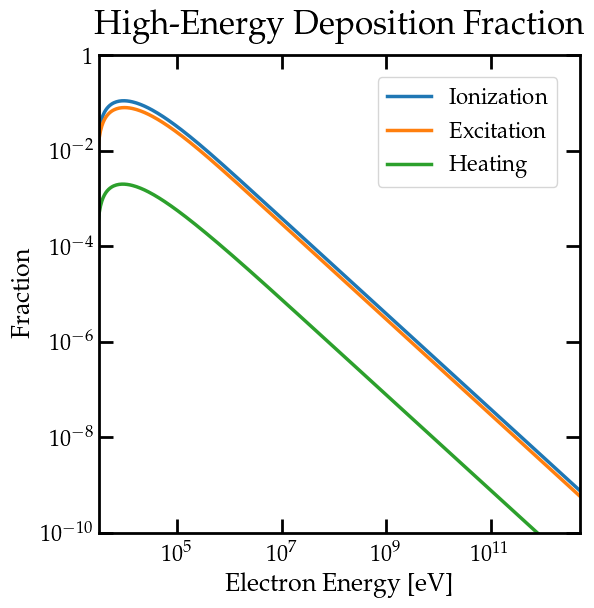

In [27]:
plt.figure()

plt.loglog()

ion_plot,  = plt.plot(eleceng, elec_dep_ion/eleceng,  label='Ionization')
exc_plot,  = plt.plot(eleceng, elec_dep_exc/eleceng,  label='Excitation')
heat_plot, = plt.plot(eleceng, elec_dep_heat/eleceng, label='Heating')

plt.xlabel('Electron Energy [eV]')
plt.ylabel('Fraction')
plt.title('High-Energy Deposition Fraction')

plt.legend(handles=[ion_plot, exc_plot, heat_plot])

plt.axis([3.2e3, 5e12, 1e-10, 1])

This plot reflects the fact that for higher energy electrons, atomic processes become less important as channels of energy deposition: instead, most of the energy is instead transferred to CMB photons that undergo inverse Compton scattering (ICS). 

## Comparing Inverse Compton Scattering and Atomic Processes

Let's explicitly compare the energy deposited into inverse Compton scattering against the energy deposited via atomic processes plus the low-energy electrons. We will ultimately reproduce the plot shown as Fig. 2 of [arXiv:1506.03812](https://arxiv.org/abs/1506.03812). 

Let's add up all the energy in atomic processes plus low-energy electrons. First, we get the low-energy electrons, which is saved as a [*TransFuncAtRedshift*](https://darkhistory.readthedocs.io/en/master/_autosummary/darkhistory/spec/transferfunction/darkhistory.spec.transferfunction.TransFuncAtRedshift.html). We can obtain the total energy for each injected electron using `TransFuncAtRedshift.toteng()`. The function `toteng()` sums over the the last axis, i.e. it sums the energy of all photons in each spectrum corresponding to an injected electron. This can then be added to the other components to get the total energy deposited as atomic processes. 

In [28]:
lowengelec_tf = elec_cooling_info[1]

eng_dep_lowengelec = lowengelec_tf.toteng()

eng_dep_atomic = eng_dep_lowengelec + elec_dep_ion + elec_dep_exc + elec_dep_heat

Now let's look at the energy deposited into ICS. This is equal to the energy stored in the secondary propagating photon spectrum, minus the initial energy of these upscattered photons. Again, we can use `TransFuncAtRedshift.toteng()` to get the total energy in the photon spectrum.

In [36]:
ICS_phot_tf = elec_cooling_info[0]

eng_dep_ICS_phot = ICS_phot_tf.toteng()

eng_dep_ICS = eng_dep_ICS_phot

All right, let's make the plot!

[1, 5000000000000.0, 0, 1.1]

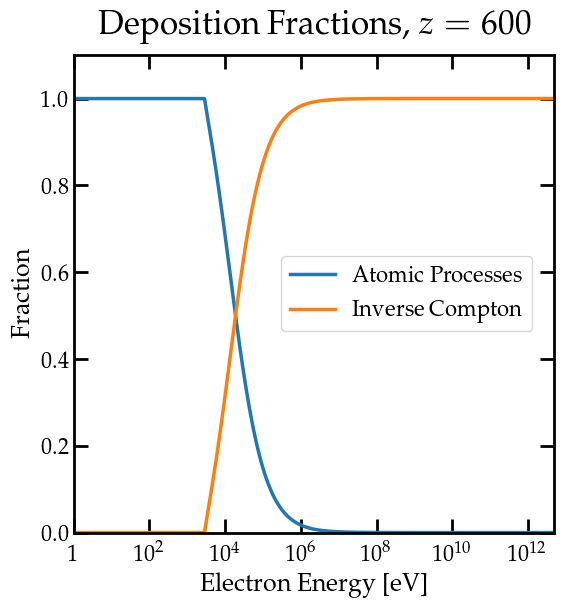

In [37]:
plt.figure()

ax = plt.gca()
ax.set_xscale('log')

atomic_plot, = plt.plot(eleceng, eng_dep_atomic/eleceng,  label='Atomic Processes')
ICS_plot,    = plt.plot(eleceng, eng_dep_ICS/eleceng,  label='Inverse Compton')

plt.xlabel('Electron Energy [eV]')
plt.ylabel('Fraction')
plt.title(r'Deposition Fractions, $z=600$')

plt.legend(handles=[atomic_plot, ICS_plot])

plt.axis([1, 5e12, 0, 1.1])

## Getting Spectra

The transfer function stored in `ICS_phot_tf` is essentially a list of photon spectra produced by a single electron at some injected energy. Acting this function by matrix multiplication on any arbitrary injection electron spectrum therefore gives the secondary photon spectrum produced after complete cooling of that spectrum. Again, we emphasize that `ICS_phot_tf` has the upscattered CMB photons **subtracted** from the spectrum. 

Let's take some electron spectrum, produced by annihilation of dark matter into a $\tau^+ \tau^-$ pair. This can be obtained from the [*darkhistory.spec.pppc*](https://darkhistory.readthedocs.io/en/master/_autosummary/darkhistory/spec/darkhistory.spec.pppc.html), which returns the same flux produced by PPPC4DMID <cite data-cite="6232408/W944VR5Z"></cite>. We'll pick $m_\text{DM}$ = 50 GeV, and obtain the spectrum per annihilation.

In [31]:
from darkhistory.spec.pppc import get_pppc_spec

mDM = 50e9

elec_spec = get_pppc_spec(mDM, eleceng, 'tau', 'elec')

`elec_spec` here is a [*Spectrum*](https://darkhistory.readthedocs.io/en/master/_autosummary/darkhistory/spec/spectrum/darkhistory.spec.spectrum.Spectrum.html) object, and contains the abscissa (`eleceng`) and the spectrum, stored as dN/dE or N. To contract this spectrum with `ICS_phot_tf`, we use the `TransferFuncAtRedshift.sum_specs`, which acts the matrix stored in `ICS_phot_tf` on the spectrum. 

In [32]:
phot_spec = ICS_phot_tf.sum_specs(elec_spec.N)

This produces a photon [*Spectrum*](https://darkhistory.readthedocs.io/en/master/_autosummary/darkhistory/spec/spectrum/darkhistory.spec.spectrum.Spectrum.html) object, with the abscissa given by `photeng`. 

We can also produce the initial spectrum of photons that got scattered. This is a blackbody spectrum, since we are only tracking photons that get upscattered in the nonrelativistic, Thomson regime (see the paper for more details). The CMB spectrum at any temperature can be obtained using [*physics.CMB_spec*](https://darkhistory.readthedocs.io/en/master/_autosummary/darkhistory/physics/darkhistory.physics.CMB_spec.html). This returns a spectrum containing $dN/(dE\, dV)$ of the CMB. 

We simply have to rescale this spectrum to the total energy of CMB photons upscattered, which is stored in the output above.   

In [38]:
eng_initial_cmb = elec_cooling_info[5]

First, let's put the spectrum in a [*Spectrum*](https://darkhistory.readthedocs.io/en/master/_autosummary/darkhistory/spec/spectrum/darkhistory.spec.spectrum.Spectrum.html) object.

In [33]:
from darkhistory.spec.spectrum import Spectrum

# Use physics.TCMB() to get the temperature at the right redshift.
CMB_spec = Spectrum(photeng, phys.CMB_spec(photeng, phys.TCMB(rs)), spec_type='dNdE')


Now, we want to rescale this spectrum so that it has the energy of the photons that got upscattered. This energy is given by `np.dot(eng_initial_cmb, elec_spec.N)`, since `eng_initial_cmb` has each bin normalized to one injected electron at some energy. 

We can do the rescaling simply by multiplying the [*Spectrum*](https://darkhistory.readthedocs.io/en/master/_autosummary/darkhistory/spec/spectrum/darkhistory.spec.spectrum.Spectrum.html) object itself. 

In [34]:
CMB_spec *= np.dot(eng_initial_cmb, elec_spec.N)/CMB_spec.toteng()


Here are the produced spectra. To recap, `elec_spec` contains the injected electron spectrum. `phot_spec` contains the secondary photon spectrum produced with the initial upscattered CMB spectrum subtracted. `CMB_spec` is that initial upscattered CMB spectrum, and `phot_spec + CMB_spec` gives the final spectrum of all photons upscattered by ICS. 

[0.0001, 1000000000000.0, 1e-10, 1e+25]

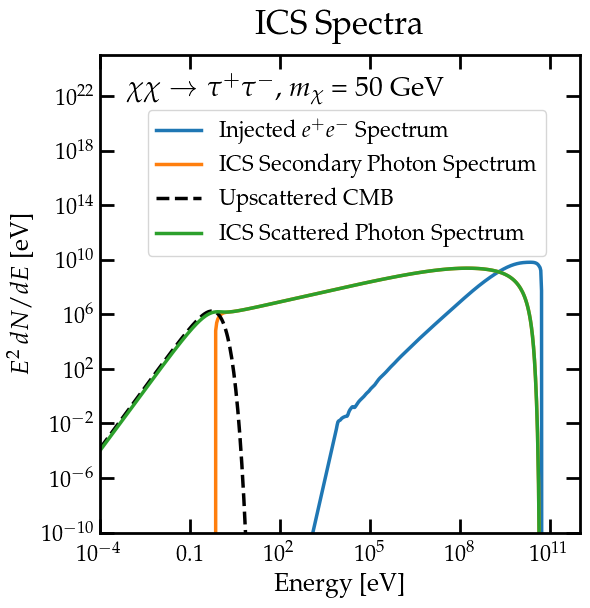

In [46]:
plt.figure()

plt.loglog()

elec_spec_plot, = plt.plot(eleceng, elec_spec.dNdE*eleceng**2, label=r'Injected $e^+e^-$ Spectrum')
phot_spec_plot, = plt.plot(photeng, phot_spec.dNdE*photeng**2, label='ICS Secondary Photon Spectrum')
CMB_plot,       = plt.plot(photeng, CMB_spec.dNdE*photeng**2,  'k--', label='Upscattered CMB')
combined_plot,  = plt.plot(photeng, (phot_spec.dNdE + CMB_spec.dNdE)*photeng**2, label='ICS Scattered Photon Spectrum')

plt.xlabel('Energy [eV]')
plt.ylabel(r'$E^2\, dN/dE$ [eV]')
plt.title('ICS Spectra')

plt.text(0.1, 0.92, r'$\chi \chi \to \tau^+\tau^-$, $m_\chi$ = 50 GeV', fontsize=20, transform=ax.transAxes) 

plt.legend(handles=[elec_spec_plot, phot_spec_plot, CMB_plot, combined_plot], loc=(0.1, 0.58))

plt.axis([1e-4, 1e12, 1e-10, 1e25])


The black dashed line shows the spectrum of photons that got upscattered as the electron spectrum (blue) cools completely, producing the final photon spectrum shown in orange. 

## Bibliography

<div class="cite2c-biblio"></div>